In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.optimize import minimize
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

# stationary dist

In [2]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g, p, C, E, ell  = sp.symbols('a b x g p C E lambda')

In [3]:
# p_i is the stationary distribution for State i
p0    = p1 / (a*(1-p)*(1-sp.exp(-(b-C)/(1-ell))) + a*p*(1-sp.Min(sp.exp(-(b-C-E)/(1-ell)),1)))
p0p   = p1 * (1-a)
p0pp  = p1 * a
p2    = p1*(a/(1-a))
prest = p1*a/(1-2*a)

In [4]:
eq = sp.Eq(p0+p0p+p0pp+prest+p1, 1)
p1_sym = sp.solve(eq, p1)[0]

In [5]:
p1_sym

a*(2*a*p*exp((-C + b)/(lambda - 1)) - 2*a*p*Min(1, exp((-C - E + b)/(lambda - 1))) - 2*a*exp((-C + b)/(lambda - 1)) + 2*a - p*exp((-C + b)/(lambda - 1)) + p*Min(1, exp((-C - E + b)/(lambda - 1))) + exp((-C + b)/(lambda - 1)) - 1)/(3*a**2*p*exp((-C + b)/(lambda - 1)) - 3*a**2*p*Min(1, exp((-C - E + b)/(lambda - 1))) - 3*a**2*exp((-C + b)/(lambda - 1)) + 3*a**2 - 2*a*p*exp((-C + b)/(lambda - 1)) + 2*a*p*Min(1, exp((-C - E + b)/(lambda - 1))) + 2*a*exp((-C + b)/(lambda - 1)) - 1)

In [6]:
p1_me = (1/(a*(1-p)*(1-sp.exp(-(b-C)/(1-ell))) + a*p*(1-sp.Min(sp.exp(-(b-C-E)/(1-ell)),1))) + 1+ (1-a)/(1-2*a))**(-1)
p1_sym.evalf(subs={a:0.3, b:3, ell:0.2, C:1, E:1, p:0.5}), p1_me.evalf(subs={a:0.3, b:3, ell:0.2, C:1, E:1, p:0.5})

(0.146274873287421, 0.146274873287421)

In [7]:
p1_me

1/(1 + 1/(a*p*(1 - Min(1, exp((C + E - b)/(1 - lambda)))) + a*(1 - p)*(1 - exp((C - b)/(1 - lambda)))) + (1 - a)/(1 - 2*a))

## FIXED

In [8]:
# 3 cases for f0
f0i_fixed   = a*C * (p*sp.Min(1,sp.exp(-(b-C-E)/(1-ell))) + (1-p)*sp.exp(-(b-C)/(1-ell)))
f0ii_fixed  = (a**2)*C * (p*(1-sp.Min(1,sp.exp(-(b-C-E)/(1-ell)))) + (1-p)*(1-sp.exp(-(b-C)/(1-ell))))
f0iii_fixed = a*(1-a)*(a+g*(1-a))*C * (p*(1-sp.Min(1,sp.exp(-(b-C-E)/(1-ell)))) + (1-p)*(1-sp.exp(-(b-C)/(1-ell))))
f0iii_fixed

C*a*(1 - a)*(a + g*(1 - a))*(p*(1 - Min(1, exp((C + E - b)/(1 - lambda)))) + (1 - p)*(1 - exp((C - b)/(1 - lambda))))

In [9]:
# explicit for f0 and f1
f0_fixed   = f0i_fixed + f0ii_fixed + f0iii_fixed
f1_fixed   = C*(a+(1-a)*a)

In [11]:
attack_full_fixed  = (p0*f0_fixed + p1*f1_fixed + C*p1*a*(2*a*(1-a)/(1-2*a)))

In [12]:
alphas = np.arange(0.01, 0.5, 0.01)
betas = np.arange(1.01, 5.01, 0.5)
gammas = [0.0, 0.25, 0.5]
p_     = 0.25
E_     = 4
C_     = 1.
g_     = 0.

subs = {C:C_, E:E_, p:p_}

attack_fixed =  attack_full_fixed.subs({p1:p1_sym}).subs(subs)

In [14]:
o_0p    = 1
o_rest = p1*a*(1-a)/(1-2*a)
orphan_full = p0p * o_0p + o_rest

eq1 = sp.Eq(orphan_full.subs({p1:p1_sym}).subs(subs), ell)

In [15]:
selfish_rews = []
for g_ in gammas:
    temp = []
    for i, a_ in tqdm(enumerate(alphas)):
        bestBeta = 100.
        bestEll  = sp.nsolve(eq1.subs({a:a_, b:bestBeta, g:g_}), ell, 0.1)
        rew      = attack_fixed.subs({a:a_, b:bestBeta, g:g_, ell:bestEll})
        temp.append(1/(1-bestEll)*rew)
    selfish_rews.append(temp)

selfish_rews = np.array(selfish_rews)
selfish_rews.shape

49it [00:02, 24.38it/s]
49it [00:01, 39.11it/s]
49it [00:01, 38.78it/s]


(3, 49)

In [16]:
def EyalSirer(a_, g_):
    num = a_*((1-a_)**2)*(4*a_+g_*(1-2*a_))-(a_**3)
    den = 1 - a_*(1+(2-a_)*a_)
    return num / den

In [17]:
ES_rews = []
for g_ in gammas:
    temp = []
    for i, a_ in tqdm(enumerate(alphas)):
        temp.append(EyalSirer(a_, g_))
    ES_rews.append(temp)
ES_rews = np.array(ES_rews)
ES_rews.shape

49it [00:00, 253729.50it/s]
49it [00:00, 270778.52it/s]
49it [00:00, 283086.63it/s]


(3, 49)

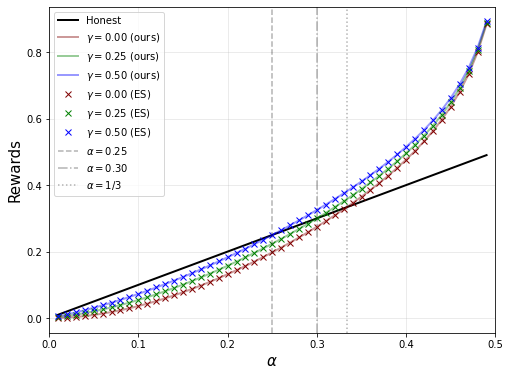

In [18]:
f, ax = plt.subplots(figsize=(8,6))

for ax_ in [ax]:
    ax_.plot(alphas, alphas, label='Honest', color='black', linewidth=2)
    ax_.plot(alphas, selfish_rews[0,:], label=r'$\gamma=0.00$ (ours)', color='maroon', linewidth=2, alpha=0.4)
    ax_.plot(alphas, selfish_rews[1,:], label=r'$\gamma=0.25$ (ours)', color='green', linewidth=2, alpha=0.4)
    ax_.plot(alphas, selfish_rews[2,:], label=r'$\gamma=0.50$ (ours)', color='blue', linewidth=2, alpha=0.4)
    
    ax_.plot(alphas, selfish_rews[0,:], label=r'$\gamma=0.00$ (ES)', color='maroon',
             marker='x', linestyle='none')
    ax_.plot(alphas, selfish_rews[1,:], label=r'$\gamma=0.25$ (ES)', color='green',
             marker='x', linestyle='none')
    ax_.plot(alphas, selfish_rews[2,:], label=r'$\gamma=0.50$ (ES)', color='blue',
             marker='x', linestyle='none')
    ax_.grid(alpha=0.3)

ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'Rewards', size=15)
ax.set_xlim(0,0.5)


ax.axvline(0.25, color='k', alpha=0.3, label=r'$\alpha=0.25$', linestyle='--')
ax.axvline(0.3, color='k', alpha=0.3, label=r'$\alpha=0.30$', linestyle='-.')
ax.axvline(1/3, color='k', alpha=0.3, label=r'$\alpha=1/3$', linestyle='dotted')

ax.legend(loc=2)
plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# selfish profitable

## FIXED

In [19]:
# 3 cases for f0
f0i_fixed   = a*C * (p*sp.Min(1,sp.exp(-(b-C-E)/(1-ell))) + (1-p)*sp.exp(-(b-C)/(1-ell)))
f0ii_fixed  = (a**2)*C * (p*(1-sp.Min(1,sp.exp(-(b-C-E)/(1-ell)))) + (1-p)*(1-sp.exp(-(b-C)/(1-ell))))
f0iii_fixed = a*(1-a)*(a+g*(1-a))*C * (p*(1-sp.Min(1,sp.exp(-(b-C-E)/(1-ell)))) + (1-p)*(1-sp.exp(-(b-C)/(1-ell))))
f0iii_fixed

C*a*(1 - a)*(a + g*(1 - a))*(p*(1 - Min(1, exp((C + E - b)/(1 - lambda)))) + (1 - p)*(1 - exp((C - b)/(1 - lambda))))

In [20]:
# explicit for f0 and f1
f0_fixed   = f0i_fixed + f0ii_fixed + f0iii_fixed
f1_fixed   = C*(a+(1-a)*a)

In [21]:
attack_full_fixed  = (p0*f0_fixed + p1*f1_fixed + C*p1*a*(2*a*(1-a)/(1-2*a)))

## Bernoulli

In [23]:
f0i_bern   = a*E * (p*sp.Min(1,sp.exp(-(b-C-E)/(1-ell))))
f0ii_bern  = (a**2)*E * (p*(1-sp.Min(1,sp.exp(-(b-C-E)/(1-ell)))))
f0iii_bern = a*(1-a)*(a+g*(1-a))*E * (p*(1-sp.Min(1,sp.exp(-(b-C-E)/(1-ell)))))
f0iii_bern

E*a*p*(1 - a)*(1 - Min(1, exp((C + E - b)/(1 - lambda))))*(a + g*(1 - a))

In [24]:
f0_bern   = f0i_bern + f0ii_bern + f0iii_bern
f1_bern   = p*E*(a+(1-a)*a)

In [25]:
attack_full_bern  = (p0*f0_bern + p1*f1_bern + p*E*p1*a*(2*a*(1-a)/(1-2*a)))

## Linear

In [26]:
f0i_lin   = a*p*(sp.Max(0,b-C-E)+(1-ell))*sp.Min(1,sp.exp(-(b-C-E)/(1-ell))) \
            + a*(1-p)*(1-ell+(b-C))*sp.exp(-(b-C)/(1-ell))
f0ii_lin  = a**2 * (p*(1-ell-(sp.Max(0,b-C-E)+1-ell)*sp.Min(1,sp.exp(-(b-C-E)/(1-ell)))) \
            + (1-p)*(1-ell-(1-ell+(b-C))*sp.exp(-(b-C)/(1-ell))))
f0iii_lin = a*((1-a)*(a+g*(1-a))) \
            * (p*(1-ell-(sp.Max(0,b-C-E)+1-ell)*sp.Min(1,sp.exp(-(b-C-E)/(1-ell)))) \
            + (1-p)*(1-ell-(1-ell+(b-C))*sp.exp(-(b-C)/(1-ell))))
f0iii_lin

a*(1 - a)*(a + g*(1 - a))*(p*(-lambda - (-lambda + Max(0, -C - E + b) + 1)*Min(1, exp((C + E - b)/(1 - lambda))) + 1) + (1 - p)*(-lambda - (-C + b - lambda + 1)*exp((C - b)/(1 - lambda)) + 1))

In [27]:
f0iii_lin.subs({p:0, C:0})

a*(1 - a)*(a + g*(1 - a))*(-lambda - (b - lambda + 1)*exp(-b/(1 - lambda)) + 1)

In [28]:
f0_lin = f0i_lin + f0ii_lin + f0iii_lin
f1_lin = (1-ell)*(a + 2*a*(1-a))

In [29]:
attack_full_lin = p0*f0_lin + p1*f1_lin + (1-ell)*p1*a*a*(3-2*a)/(1-2*a)

In [30]:
gammas = np.arange(0.001, 1.1, 0.1)
alphas = np.arange(0.01, 0.50, 0.01)
betas = np.arange(1.01, 5.01, 0.5)

In [31]:
p_ = 0.5
C_ = 1.
E_ = 2.

In [32]:
subs = {C:C_, E:E_, p:p_}

In [33]:
attack_fixed =  attack_full_fixed.subs({p1:p1_sym}).subs(subs)
attack_lin   =  attack_full_lin.subs({p1:p1_sym}).subs(subs)

In [34]:
full_rews = (attack_full_fixed + attack_full_bern + attack_full_lin).subs({p1:p1_sym}).subs(subs)